In [1]:
import os
from enum import Enum

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import albumentations as A

In [2]:
df = pd.read_csv('datasets/train/train.csv')
df

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


In [30]:
def age_to_label(age: int):
    if age < 30:
        return 0
    elif age < 60:
        return 1
    else:
        return 2

def show_countplot(df: pd.DataFrame):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    sns.countplot(data=df, x="gender", ax=axes[0])
    sns.countplot(data=df, x="race", ax=axes[1])
    
    # df['clipped_age'] = df['age'].map(age_to_label)
    sns.countplot(data=df, x=df['age'].map(age_to_label), ax=axes[2])
    axes[2].set_xticklabels(['-30', '30-60', '60-'])
    
    plt.suptitle("Count plot for each attribute", fontsize=20)
    plt.tight_layout()
    plt.show()

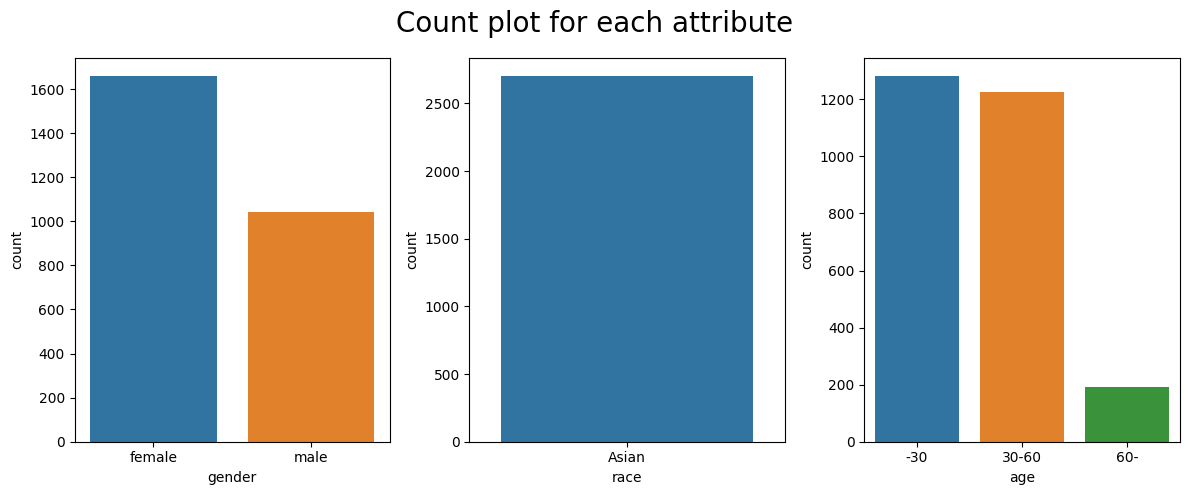

In [31]:
show_countplot(df)

### Dataset Treeview
```
${DATASET_ROOT}
  ├─ train
  │   └─ train.csv  
  │   └─ .train.csv
  │   └─ ._images
  │   └─ images
  │       └─ xxx
  │           └─ xxx.jpg
  │           └─ .xxx.jpg
  │       └─ .xxx
  │           └─ xxx.jpg
  │           └─ .xxx.jpg
  └─ eval
      └─ images
```
=> 2700 column * 7 (5 mask images + 1 incorrect_mask + 1 normal) <br>
=> make new column in 'df' which can load image by path

In [2]:
def remove_train_dot(root_dir: os.PathLike):
    '''
    This Function removes the train data that starts with a dot('._xxx')
    '''
    img_paths = []
    print(len(list(filter(lambda x: not x.startswith('.'), os.listdir(root_dir)))))
    for candidate in list(filter(lambda x: not x.startswith('.'), os.listdir(root_dir))):
        for sub_candidate in os.listdir(os.path.join(root_dir, candidate)):
            if not sub_candidate.startswith('.'):
                img_paths.append([candidate, os.path.join(root_dir, candidate, sub_candidate)])
    return img_paths

In [33]:
removed_train_data = remove_train_dot('datasets/train/images')

2700


In [34]:
class MaskLabels(int, Enum):
    wear: int = 0
    incorrect: int = 1
    not_wear: int = 2
    
    @classmethod
    def get_label(self, label: str) -> int:
        if label.startswith("mask"):
            return self.wear
        elif label.startswith('incorrect'):
            return self.incorrect
        elif label.startswith('normal'):
            return self.not_wear
        else:
            raise KeyError(f'{label} is not exist in MaskLabels')
       

class GenderLabel(int, Enum):
    male: int = 0
    female: int = 1
    
    @classmethod
    def get_label(self, gender: str) -> int:
        if gender == "male":
            return self.male
        else:
            return self.female


class AgeLabel(int, Enum):
    young: int = 0
    middle: int = 1
    old: int = 2
    
    @classmethod
    def get_label(self, age: int) -> int:
        if age < 30:
            return self.young
        elif age < 60:
            return self.middle
        else:
            return self.old    

In [35]:
df_rows = []

for folder_name in df['path']:
    candidates = list(filter(lambda x: x[0]==folder_name, removed_train_data))
    _, gender, _, age = folder_name.split('_')
    gender = GenderLabel.get_label(gender)
    age = AgeLabel.get_label(int(age))
    for _, abs_path in candidates:
        mask = abs_path.split('/')[-1].split('.')[0]
        mask = MaskLabels.get_label(mask)
        total_label = mask*6 + gender*3 + age
        df_rows.append([abs_path, gender, age, mask, total_label])
  
new_traindf = pd.DataFrame(df_rows, columns=['path', 'gender_label', 'age_label', 'mask_label','label'])

In [19]:
new_traindf.to_csv("datasets/train/new_train.csv", index=False)

/tmp/ipykernel_83276/1166141783.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['male', 'female'])
/tmp/ipykernel_83276/1166141783.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['-30', '30-60', '60-'])
/tmp/ipykernel_83276/1166141783.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(['wear', 'incorrect', 'not_wear'])


Text(0.5, 0.98, 'Count plot for each attribute')

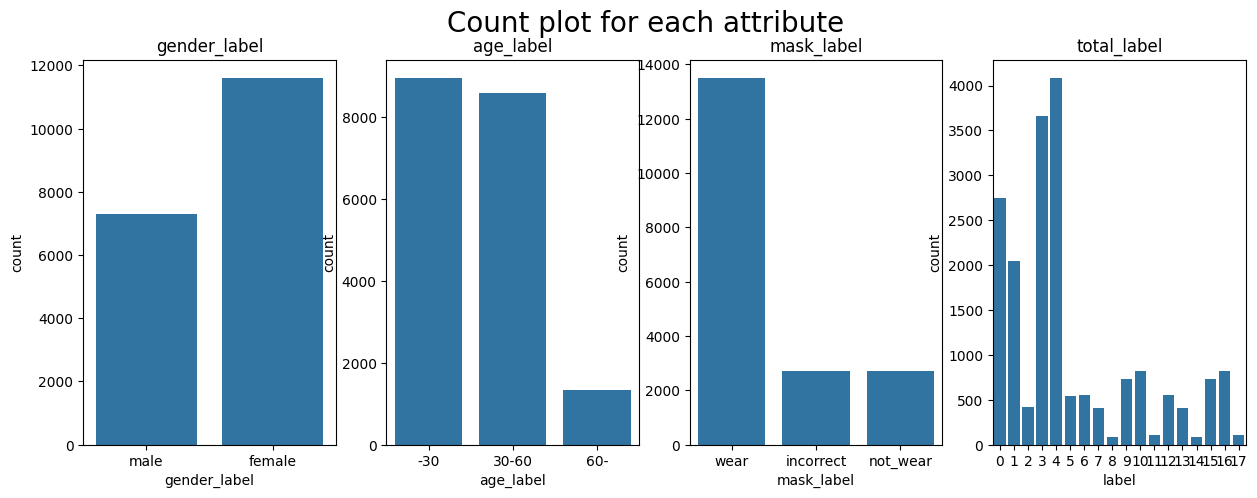

In [22]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
sns.countplot(data=new_traindf, x='gender_label', ax=axes[0])
axes[0].set_title("gender_label")
axes[0].set_xticklabels(['male', 'female'])

sns.countplot(data=new_traindf, x='age_label', ax=axes[1])
axes[1].set_title("age_label")
axes[1].set_xticklabels(['-30', '30-60', '60-'])

sns.countplot(data=new_traindf, x='mask_label', ax=axes[2])
axes[2].set_title("mask_label")
axes[2].set_xticklabels(['wear', 'incorrect', 'not_wear'])

sns.countplot(data=new_traindf, x='label', ax=axes[3])
axes[3].set_title("total_label")

plt.suptitle("Count plot for each attribute", fontsize=20)

### Visualize with Augmentations

In [36]:
df = pd.read_csv("datasets/train/new_train.csv")
df.head()

,path,gender_label,age_label,mask_label,label
0,datasets/train/images/000001_female_Asian_45/i...,1,1,1,10
1,datasets/train/images/000001_female_Asian_45/m...,1,1,0,4
2,datasets/train/images/000001_female_Asian_45/m...,1,1,0,4
3,datasets/train/images/000001_female_Asian_45/m...,1,1,0,4
4,datasets/train/images/000001_female_Asian_45/n...,1,1,2,16


In [48]:
def show_augmented_images(df: pd.DataFrame, rows: int, cols: int, transforms):
    fig, axes = plt.subplots(rows, cols, figsize=(7, 4))
    random_idxs = np.random.randint(len(df), size=rows*cols)
    axes = axes.flatten()
    
    for i, idx in enumerate(random_idxs):
        image = Image.open(df.iloc[idx]['path']).convert('RGB')
        image = np.array(image).astype(np.uint8)
        image = transforms(image=image)['image']
        label = df.iloc[idx]['label']
        
        axes[i].imshow(image)
        axes[i].set_title(f'label: {label}')
        axes[i].axis('off')   
        
    plt.tight_layout()
    plt.show()    

CenterCrop

In [49]:
center_crop = A.Compose([
    A.CenterCrop(256, 256)
])

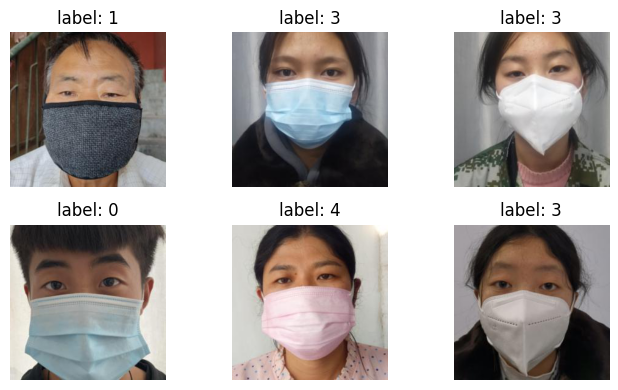

In [50]:
show_augmented_images(df, 2, 3, center_crop)

Gaussian Blur

In [51]:
gaussian_blur = A.Compose([
    A.GaussianBlur(blur_limit=(3, 7), p=1),
])

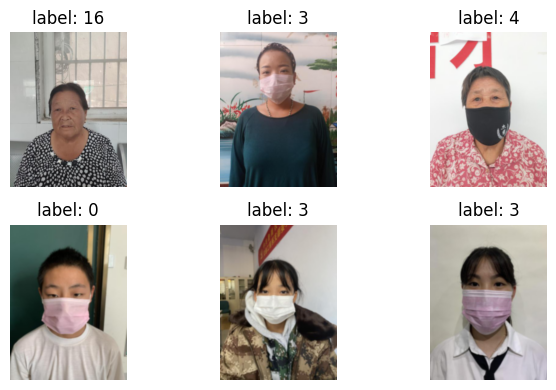

In [52]:
show_augmented_images(df, 2, 3, gaussian_blur)

In [53]:
color_jitter = A.Compose([
    A.CenterCrop(256, 256),
    A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.7, p=1)
])

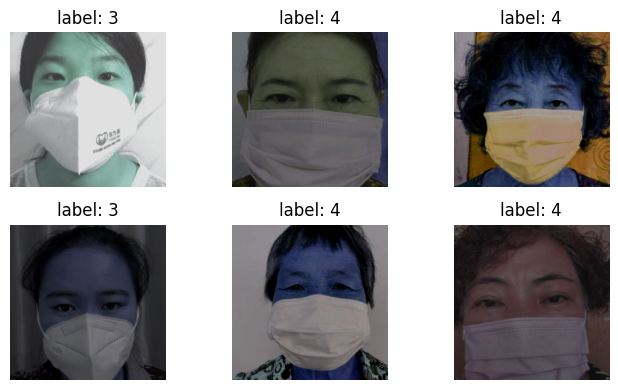

In [54]:
show_augmented_images(df, 2, 3, color_jitter)

In [55]:
random_brightness = A.Compose([
    A.CenterCrop(256, 256),
    A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=1),
    A.ColorJitter(brightness=0, contrast=0.3, saturation=0, hue=0.3, p=1)
])

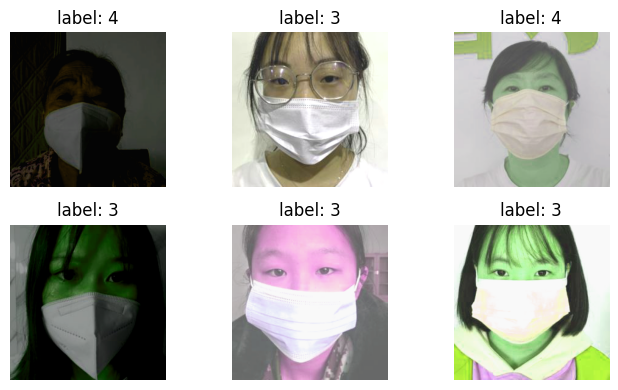

In [56]:
show_augmented_images(df, 2, 3, random_brightness)

### Test Dataset Visualization

In [4]:
def extract_eval_data(eval_csv):
    ''' This Function extracts the eval data from eval_csv
    Args:
        eval_csv (os.PathLike): eval csv file path
    Returns:
        img_paths (list): list of [label, image_path]
    '''
    df = pd.read_csv(eval_csv)
    return [os.path.join("datasets", "eval", "images", x) for x in df['ImageID']]

In [5]:
test_data = extract_eval_data("datasets/eval/submission.csv")
test_df = pd.read_csv("datasets/eval/submission.csv")

In [6]:
def show_test_images(test_data: list, rows: int, cols: int):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    random_idxs = np.random.randint(len(test_data), size=rows*cols)
    axes = axes.flatten()
    
    for i, idx in enumerate(random_idxs):
        image = Image.open(test_data[idx]).convert('RGB')
        label = test_df[test_df['ImageID']==test_data[idx].split('/')[-1]]['ans'].values[0]
        axes[i].set_title(f'label: {label}')
        axes[i].imshow(image)
        axes[i].axis('off')   
        
    plt.tight_layout()
    plt.show()

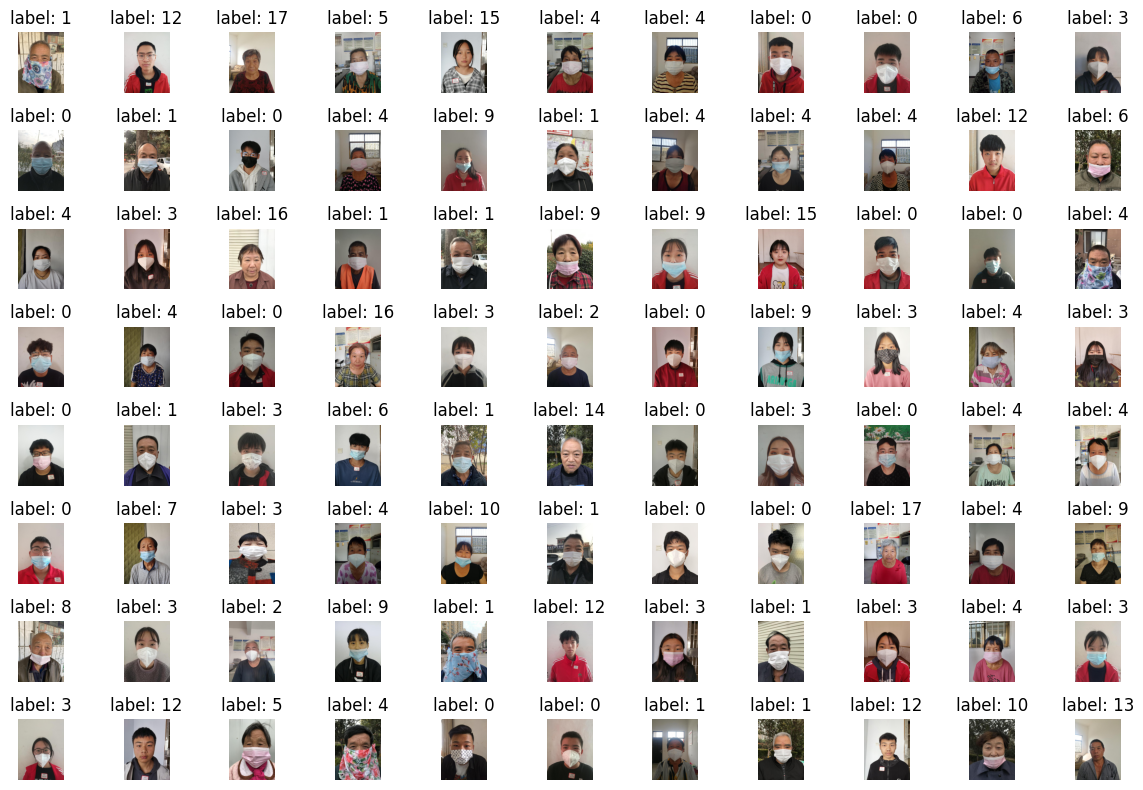

In [7]:
show_test_images(test_data, 8, 11)

In [2]:
test_df = pd.read_csv("datasets/eval/submission.csv")

In [16]:
from src.dataset import MaskMultiLabelDataset
from src.model import BaseModel
from albumentations.pytorch import ToTensorV2

transforms = A.Compose([
    A.Resize(384, 384),
    A.Normalize(
        mean=(0.56019358, 0.52410121, 0.501457),
        std=(0.23318603, 0.24300033, 0.24567522)
    ),
    ToTensorV2(),
])

train_dataset = MaskMultiLabelDataset(
    pd.read_csv("datasets/train/new_train.csv"),
    transforms
)

In [46]:
import torch
from torch.utils.data import DataLoader


def cutmix(batch, alpha=1.0):
    images, *labels = batch
    gender, age, mask, _ = labels

    # 이미지의 크기 및 랜덤 비율 설정
    B, C, H, W = images.shape
    lam = np.random.beta(alpha, alpha)
    
    # 랜덤 위치 설정
    cx = np.random.uniform(0, W)
    cy = np.random.uniform(0, H)
    w = W * np.sqrt(1 - lam)
    h = H * np.sqrt(1 - lam)
    x0 = int(np.clip(cx - w / 2, 0, W))
    x1 = int(np.clip(cx + w / 2, 0, W))
    y0 = int(np.clip(cy - h / 2, 0, H))
    y1 = int(np.clip(cy + h / 2, 0, H))

    # 이미지 샘플링 및 혼합
    indices = torch.randperm(B)
    mixed_images = images.clone()
    mixed_images[:, :, y0:y1, x0:x1] = images[indices, :, y0:y1, x0:x1]
    
    # 레이블 조정
    lam = 1 - ((x1 - x0) * (y1 - y0) / (W * H))
    mixed_gender = (gender, gender[indices], lam)
    mixed_age = (age, age[indices], lam)
    mixed_mask = (mask, mask[indices], lam)
        
    return mixed_images, (mixed_gender, mixed_age, mixed_mask)

In [47]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False, num_workers=4)
model = BaseModel(num_classes=8).cuda()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])
(tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]), tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]), 0.7191365559895833)


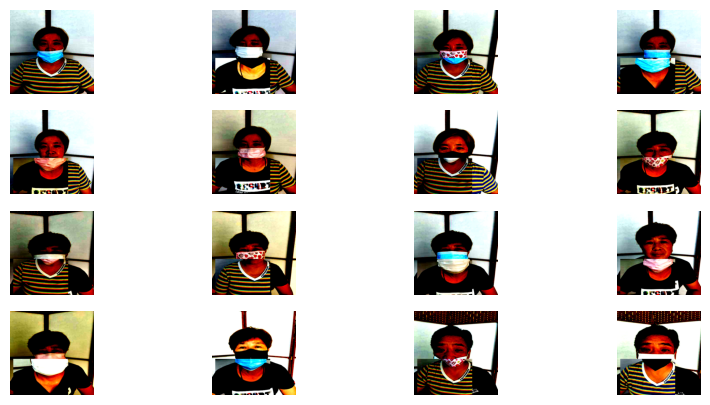

In [48]:
fig, axes = plt.subplots(4, 4, figsize=(10, 5))

for idx, batch in enumerate(train_dataloader):
    imgs, *labels = cutmix(batch)       
    for i, img in enumerate(imgs):
        axes[i//4][i%4].imshow(img.permute(1, 2, 0))
        axes[i//4][i%4].axis('off')
    
    # if idx == 10:
    break

plt.show()

In [2]:
img_name = "91598d7dad0122459e004ecd8a4e745acbd63101"
img_paths = os.path.join("datasets","eval","images", f"{img_name}.jpg")

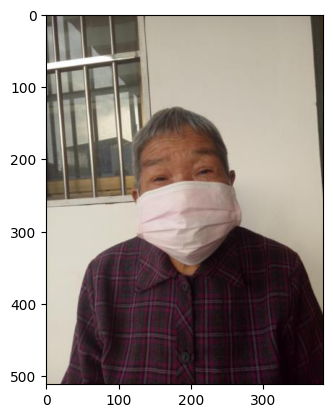

In [3]:
plt.imshow(Image.open(img_paths).convert('RGB'))
plt.show()